In [1]:
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs, make_circles
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import requests 
from collections import Counter

In [2]:
##------------------------------Pegando os Dados-----------------------------------

url = "https://apitempo.inmet.gov.br/estacao/diaria/2018-01-01/2020-12-31/A307"
headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'}
resp = requests.get(url, headers=headers)
df = None
if resp.status_code != 200:
    print (resp.raise_for_status())
else:
    df = pd.DataFrame(resp.json())
    #df = df[df["TEM_MAX"].astype('float') ]
    df_temp = df[df['TEMP_MAX'].notnull()]
    df_temp = df[df['UMID_MED'].notnull()]
    
    df_temp = df[['TEMP_MAX', 'UMID_MED']]
    df_temp["id"] = df.index + 1 

    df_umid = df[df['UMID_MED'].notnull()]
    df_umid = df[['UMID_MED']]
    #df_umid["id"] = df.index + 1

<ipython-input-2-fb496ac972b8>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp["id"] = df.index + 1


In [43]:
#------------------------------Tratando os Dados-----------------------------------

df_training_temp = None
df_training_temp_anomalie_edit = None
desvioPadraoTempTraining = 0
desvioPadraoUmidTraining = 0

desvioPadraoTempTest = 0
desvioPadraoUmidTest = 0

desvioPadrao = 0

def valorFinalTemperatura(df_training_temp_anomalie_edit, treino):
    valorMediaTemp = df_training_temp_anomalie_edit['TEMP_MAX'].sum()/df_training_temp_anomalie_edit.shape[0]
    desvioPadraoTemp = df_training_temp_anomalie_edit["TEMP_MAX"].std()
    if treino:
        desvioPadraoTempTraining = desvioPadraoTemp
        print (desvioPadraoTempTraining)
    else:
        desvioPadraoTempTest = desvioPadraoTemp
        print (desvioPadraoTempTest)
    desvioPadraoEditadoTemp = 3 * desvioPadraoTemp
    valorFinalTemp = desvioPadraoEditadoTemp + valorMediaTemp
    return valorFinalTemp

def valorFinalUmidade(df_training_temp_anomalie_edit):
    valorMediaUmid = df_training_temp_anomalie_edit['UMID_MED'].sum()/df_training_temp_anomalie_edit.shape[0]
    desvioPadraoUmid = df_training_temp_anomalie_edit["UMID_MED"].std()
    desvioPadraoUmidTraining = desvioPadraoUmid
    desvioPadraoEditadoUmid = 3 * desvioPadraoUmid
    valorFinalUmid = desvioPadraoEditadoUmid + valorMediaUmid
    return valorFinalUmid

def qtdRowsTemp():
    count_row_temp = df_temp.shape[0]
    return count_row_temp

def dataTraining(percentOutliers):    
    qtd_training_temp = int(qtdRowsTemp()/3) * 2

    df_training_temp = df_temp.sample(qtd_training_temp) # 2/3 de dados de treino

    count_training_temp = int((df_training_temp.shape[0] * percentOutliers) / 100)
    
    df_training_temp_anomalie_edit = df_training_temp.sample(count_training_temp)

    df_test_temp = pd.concat([df_temp, df_training_temp]).drop_duplicates(keep=False)

    df_training_temp = pd.concat([df_training_temp, df_training_temp_anomalie_edit]).drop_duplicates(keep=False)
    df_training_temp_anomalie_edit.dropna(inplace=True)

    df_training_temp_anomalie_edit["TEMP_MAX"] = df_training_temp_anomalie_edit["TEMP_MAX"].astype(float)
    df_training_temp_anomalie_edit["UMID_MED"] = df_training_temp_anomalie_edit["UMID_MED"].astype(float)

    valorFinalTemp = valorFinalTemperatura(df_training_temp_anomalie_edit, True)
    valorFinalUmid = valorFinalUmidade(df_training_temp_anomalie_edit)

    df_training_temp_anomalie_edit["TEMP_MAX"] = df_training_temp_anomalie_edit["TEMP_MAX"].add(valorFinalTemp)
    df_training_temp_anomalie_edit["UMID_MED"] = df_training_temp_anomalie_edit["UMID_MED"].add(valorFinalUmid)

    df_training_temp = pd.concat([df_training_temp, df_training_temp_anomalie_edit])
    df_training_temp.sort_values(by=['id'])

    #Treino
    df_training_temp["TEMP_MAX"] = df_training_temp["TEMP_MAX"].astype(float)
    df_training_temp["UMID_MED"] = df_training_temp["UMID_MED"].astype(float)
    df_training_temp.dropna(inplace=True)
    df_training_temp = df_training_temp.drop(columns='id')

    #Teste
    count_test_temp = int((df_test_temp.shape[0] * percentOutliers) / 100)
    df_test_temp_anomalie_edit = df_test_temp.sample(count_test_temp)
    df_test_temp = pd.concat([df_test_temp, df_test_temp_anomalie_edit]).drop_duplicates(keep=False)
    df_test_temp_anomalie_edit.dropna(inplace=True)
    
    df_test_temp_anomalie_edit["TEMP_MAX"] = df_test_temp_anomalie_edit["TEMP_MAX"].astype(float)
    df_test_temp_anomalie_edit["UMID_MED"] = df_test_temp_anomalie_edit["UMID_MED"].astype(float)
    
    valorFinalTemp = valorFinalTemperatura(df_test_temp_anomalie_edit, False)
    valorFinalUmid = valorFinalUmidade(df_test_temp_anomalie_edit)
    
    df_test_temp_anomalie_edit["TEMP_MAX"] = df_test_temp_anomalie_edit["TEMP_MAX"].add(valorFinalTemp)
    df_test_temp_anomalie_edit["UMID_MED"] = df_test_temp_anomalie_edit["UMID_MED"].add(valorFinalUmid)

    df_test_temp = pd.concat([df_test_temp, df_test_temp_anomalie_edit])
    df_test_temp.sort_values(by=['id'])
    
    df_test_temp["TEMP_MAX"] = df_test_temp["TEMP_MAX"].astype(float)
    df_test_temp["UMID_MED"] = df_test_temp["UMID_MED"].astype(float)
    
    df_test_temp.dropna(inplace=True)
    df_test_temp = df_test_temp.drop(columns='id')
    desvioPadrao = (desvioPadraoTempTraining + desvioPadraoUmidTraining) / 2
    return df_training_temp, df_test_temp

In [89]:
dfs = dataTraining(2)
df_training_temp = dfs[0]
df_test_temp = dfs[1]

2.1729986371194703
2.9262604121984768


(663, 2)
Quantidade outliers: (13, 2)


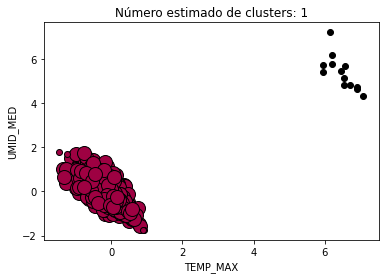

In [96]:
#------------------------------Implementando o DBSCAN-----------------------------------
def dbscan_part1(df, eps, min_samples):
    #X = np.array([ [1, 2], [2, 2], [7, 6], [28, 7], [2, 3], [25, 8], [3, 2],[1, 3],[1.1, 2],[1.2, 2],[1.3, 2],[1.4, 2]])
    X = np.array(df)
    X = StandardScaler().fit_transform(X)
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(X)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True

    labels = db.labels_

    outliers = df[db.labels_ == -1]

    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each)
              for each in np.linspace(0, 1, len(unique_labels))]
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Preto usado para ruído
            col = [0, 0, 0, 1]

        class_member_mask = (labels == k)

        xy = X[class_member_mask & core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=14)

        xy = X[class_member_mask & ~core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=6)

    #print('Outliers encontrados: ')
    #print (outliers)
    print ("Quantidade outliers: " + str(outliers.shape))

    plt.title('Número estimado de clusters: %d' % n_clusters_)
    plt.xlabel("TEMP_MAX")
    plt.ylabel("UMID_MED")
    plt.show()  

eps = 0.5
min_samples = 7
print (df_training_temp.shape)
dbscan_part1(df_training_temp, eps, min_samples)
#print (desvioPadraoTemp)

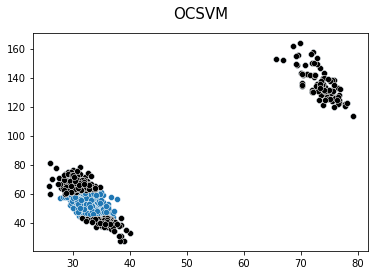

In [68]:
from sklearn.svm import OneClassSVM
import seaborn as sns

df_training_temp = df_training_temp

X = np.array(df_training_temp)
X, _ = make_blobs(n_samples=df_training_temp.shape[0], centers=X, cluster_std=0.4,random_state=None)

ocsvm = OneClassSVM(kernel='rbf', degree=3, gamma='scale', nu=0.5, coef0=0.0,tol=0.001,
                    shrinking=True,cache_size=200,
                    verbose=False,max_iter=-1).fit(X)
pred = ocsvm.predict(X)
outlier_index = np.where(pred==-1)
outlier_values = X[outlier_index]

sns.scatterplot(x=X[:,0], y=X[:,1])
sns.scatterplot(x=outlier_values[:,0], 
                y=outlier_values[:,1], color='black')
plt.title("OCSVM", fontsize=15, pad=15)
plt.savefig("One-Class SVM Detection.png", dpi=80)

[[ 29.8         50.        ]
 [ 28.8         73.2       ]
 [ 28.2         63.5       ]
 [ 28.          66.5       ]
 [ 28.2         70.8       ]
 [ 27.9         69.4       ]
 [ 38.3         43.        ]
 [ 28.3         58.2       ]
 [ 37.9         38.1       ]
 [ 32.8         74.3       ]
 [ 25.7         69.8       ]
 [ 28.4         73.4       ]
 [ 34.5         65.4       ]
 [ 32.2         71.3       ]
 [ 26.7         78.2       ]
 [ 28.1         59.8       ]
 [ 39.3         27.7       ]
 [ 34.3         64.        ]
 [ 37.5         55.5       ]
 [ 37.9         30.8       ]
 [ 29.          70.1       ]
 [ 37.3         35.8       ]
 [ 40.1         33.        ]
 [ 38.7         34.5       ]
 [ 30.7         75.3       ]
 [ 36.7         33.5       ]
 [ 34.5         37.        ]
 [ 37.5         34.8       ]
 [ 30.7         73.5       ]
 [ 30.8         78.5       ]
 [ 33.          72.        ]
 [ 30.8         74.4       ]
 [ 29.7         74.5       ]
 [ 29.4         75.        ]
 [ 31.        

Text(0, 0.5, 'UMID_MED')

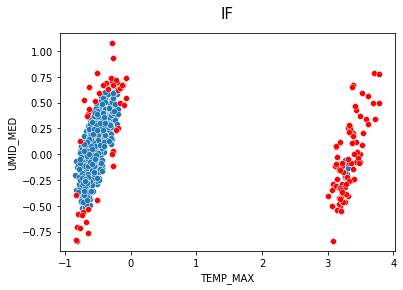

In [88]:
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
import seaborn as sns

X = np.array(df_training_temp)

iforest = IsolationForest(n_estimators=90, max_samples=df_training_temp.shape[0], 
                          warm_start=False,
                          contamination=0.2, max_features=1.0, 
                          bootstrap=False, n_jobs=None, random_state=None)

pred = iforest.fit_predict(X)
outlier_index = np.where(pred==-1)
outlier_values = X[outlier_index]

print (outlier_values)
sc=StandardScaler()
X_scaled = sc.fit_transform(X)
outlier_values_scaled = sc.transform(outlier_values)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
outlier_values_pca = pca.transform(outlier_values_scaled)

sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1])
sns.scatterplot(x=outlier_values_pca[:,0], 
                y=outlier_values_pca[:,1], color='r')
plt.title("IF", fontsize=15, pad=15)
plt.xlabel("TEMP_MAX")
plt.ylabel("UMID_MED")

In [75]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager
from sklearn import svm

X_test = np.array(df_test_temp)
X_train = np.array(df_training_temp)

# fit the model
clf = svm.OneClassSVM(nu=0.5, kernel="rbf", gamma='scale').fit(X_train)
y_pred_train = clf.predict(X_train)
print (y_pred_train)
print ()
y_pred_test = clf.predict(X_test)
print (y_pred_test)

'''
outlier_index = np.where(y_pred_train==-1)
outlier_values = X_train[outlier_index]
print (outlier_values)
'''


[ 1  1 -1 -1  1  1  1 -1  1 -1 -1 -1 -1  1 -1  1  1  1  1  1  1 -1 -1 -1
 -1 -1  1 -1  1  1 -1  1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1 -1  1  1  1
 -1 -1 -1  1  1 -1  1 -1 -1 -1  1  1 -1  1  1  1  1  1  1  1  1  1 -1  1
  1 -1  1  1  1  1 -1  1  1 -1 -1 -1  1 -1  1 -1 -1  1  1  1 -1 -1  1  1
  1  1  1  1  1 -1  1 -1 -1 -1 -1  1 -1 -1  1 -1 -1  1  1  1  1  1  1  1
 -1  1  1 -1  1  1  1 -1 -1  1  1  1  1  1  1  1  1  1 -1 -1  1 -1 -1  1
  1  1  1  1 -1  1 -1 -1 -1 -1 -1 -1  1  1 -1 -1 -1 -1  1  1 -1 -1  1 -1
 -1 -1  1  1  1  1  1  1 -1 -1 -1  1 -1 -1 -1  1  1 -1 -1  1  1  1 -1 -1
  1  1  1  1  1  1  1 -1 -1  1  1 -1 -1 -1  1  1 -1 -1  1 -1  1 -1 -1 -1
  1  1 -1  1 -1 -1  1 -1  1  1 -1  1  1  1 -1  1 -1  1 -1  1  1  1  1  1
  1  1 -1  1  1 -1 -1 -1  1 -1  1 -1  1 -1 -1  1  1 -1  1  1 -1  1  1  1
 -1  1 -1  1 -1 -1 -1  1  1  1  1  1 -1  1  1  1 -1 -1 -1 -1  1  1  1 -1
  1  1 -1 -1  1 -1 -1  1  1  1 -1  1  1  1  1 -1  1 -1  1 -1 -1  1  1  1
 -1 -1  1 -1 -1 -1  1 -1 -1 -1 -1  1 -1 -1 -1  1  1

'\noutlier_index = np.where(y_pred_train==-1)\noutlier_values = X_train[outlier_index]\nprint (outlier_values)\n'